# COGS 118B Final Project (Group RILS): All Code #

## General Process 
(Written at like 1am so sorry if the writing isn't the best)

### 1: Data cleaning
Figure out how to get data from kaggle api

import data from kaggle

Drop irrelevant columns 
Split - seperated columns (genre, credits, etc) 
Drop NA/bad data 


### 2: PCA

Create artificial weighting for Genre (and anything else we deem important)
Find PCA post weighting
Determine number of componenets to be using based on variance explained


### 3: Clustering

Based on PCA (or other DR method if it works better) iterate through a number of potential clusters to find elbow method
Decide on best clustering arrangement
Cluster based on that arrangement

Everything above here we kinda did already we just need to fine tune it
### 4: Evaluation

Using sillhouette score get a rough estimate of how well the model is performing. If this looks really bad, go back to steps 2 & 3 to make changes before continuing. 

Create a pseudo rand index score: For each datapoint (or maybe for a subset of them if the computation is taking a while), get the movies from the recomendations column. Then check if those movies are in the same cluster in our clustering method. Get some metric of accuracy (could just be # recommended in cluster/total # recommended). Again, if this looks really bad, go back to steps 2 & 3 to make changes before continuing. 


### 5: Regression

Recommender system steps:
1. Take an input movie in
2. Check if the input movie is in our dataset
3. If it's in our dataset, find the cluster it's in from part 3, and subset the data to just that.
4. Within this cluster, calculate the euclidean distance to every other movie.
5. Create a regression (logistic or linear) to put out which movies are good based on euclidean distance, vote average, popularity, (anything else you think is important) which outputs/predicts the movies given by the recommendation column
6. Train this regression (or fine tune it).


### 6: Writeup

That's kinda all there needs to be for code, unless we finish that and decide we want to build a GUI or add a bit to pull the poster images + tagline from earlier in the dataset.
Writeup the submission part of it and we're done :)


# 1) Data Cleaning #

In [1]:
import pandas as pd
import numpy as np

## Load Data ##

In [2]:
df = pd.read_csv('movies.csv')
df.head()
df.shape[0]

722480

## Drop Irrelevant Columns ##

In [3]:
columns_to_remove = ['overview', 'keywords', 'poster_path', 'backdrop_path']
df = df.drop(columns = columns_to_remove)
df.head()

,id,title,genres,original_language,popularity,production_companies,release_date,budget,revenue,runtime,status,tagline,vote_average,vote_count,credits,recommendations
0,615656,Meg 2: The Trench,Action-Science Fiction-Horror,en,8763.998,Apelles Entertainment-Warner Bros. Pictures-di...,2023-08-02,129000000.0,352056482.0,116.0,Released,Back for seconds.,7.079,1365.0,Jason Statham-Wu Jing-Shuya Sophia Cai-Sergio ...,1006462-298618-569094-1061181-346698-1076487-6...
1,758323,The Pope's Exorcist,Horror-Mystery-Thriller,en,5953.227,Screen Gems-2.0 Entertainment-Jesus & Mary-Wor...,2023-04-05,18000000.0,65675816.0,103.0,Released,Inspired by the actual files of Father Gabriel...,7.433,545.0,Russell Crowe-Daniel Zovatto-Alex Essoe-Franco...,713704-296271-502356-1076605-1084225-1008005-9...
2,667538,Transformers: Rise of the Beasts,Action-Adventure-Science Fiction,en,5409.104,Skydance-Paramount-di Bonaventura Pictures-Bay...,2023-06-06,200000000.0,407045464.0,127.0,Released,Unite or fall.,7.340,1007.0,Anthony Ramos-Dominique Fishback-Luna Lauren V...,496450-569094-298618-385687-877100-598331-4628...
3,640146,Ant-Man and the Wasp: Quantumania,Action-Adventure-Science Fiction,en,4425.387,Marvel Studios-Kevin Feige Productions,2023-02-15,200000000.0,475766228.0,125.0,Released,Witness the beginning of a new dynasty.,6.507,2811.0,Paul Rudd-Evangeline Lilly-Jonathan Majors-Kat...,823999-676841-868759-734048-267805-965839-1033...
4,677179,Creed III,Drama-Action,en,3994.342,Metro-Goldwyn-Mayer-Proximity Media-Balboa Pro...,2023-03-01,75000000.0,269000000.0,116.0,Released,You can't run from your past.,7.262,1129.0,Michael B. Jordan-Tessa Thompson-Jonathan Majo...,965839-267805-943822-842942-1035806-823999-107...


## Drop Duplicates ##

In [4]:
df_no_duplicates = df.drop_duplicates()
df_no_duplicates.shape[0]

722462

## Drop Na Values ##

In [5]:
df_cleaned = df_no_duplicates.dropna(subset=['recommendations'])
df_cleaned.head()
df_cleaned.shape[0]

34894

## One Hot Encoding for Production Companies, Credits, and Genre ##

In [6]:
from collections import Counter

In [7]:
df_copy = df.copy()

# Handling missing values by replacing NaNs with an empty string
df_copy['production_companies'] = df_copy['production_companies'].fillna('')
df_copy['credits'] = df_copy['credits'].fillna('')

# Splitting the production companies by '-' and flattening the list
all_companies = [company for sublist in df_copy['production_companies'].apply(lambda x: str(x).split('-')) for company in sublist]

# Filter companies occurring at least 1750 times and are not empty
company_counts = Counter(all_companies)
unique_companies = [company for company, count in company_counts.items() if count >= 1750 and company != '']

print("Unique Companies:", unique_companies)
print("Number of Unique Companies:", len(unique_companies))

# Company One Hot Encoding
company_data = {}
for company in unique_companies:
    company_data[company] = df_copy['production_companies'].apply(lambda x: 1 if company in x else 0)

# Splitting the credits by '-' and flattening the list
all_credits = [credit for sublist in df_copy['credits'].apply(lambda x: str(x).split('-')) for credit in sublist]

# Filter credits occurring at least 400 and are full names (at least 2 names)
credit_counts = Counter(all_credits)
unique_credits = [credit for credit, count in credit_counts.items() if count >= 400 and len(credit.split()) >= 2]

print("Unique Credits:", unique_credits)
print("Number of Unique Credits:", len(unique_credits))

# Credits One Hot Encoding
credit_data = {}
for credit in unique_credits:
    credit_data[credit] = df_copy['credits'].apply(lambda x: 1 if credit in x else 0)

credit_df = pd.DataFrame(credit_data)
df_copy = pd.concat([df_copy, credit_df], axis=1)
company_df = pd.DataFrame(company_data)
df_copy = pd.concat([df_copy, company_df], axis=1)

Unique Companies: ['Warner Bros. Pictures', 'Paramount', 'Metro', 'Goldwyn', 'Mayer', 'Universal Pictures', 'Columbia Pictures', 'Toei Company', 'ARTE', 'ZDF', 'Film', 'ONF | NFB', 'BBC']
Number of Unique Companies: 13
Unique Credits: ['Frank Welker', 'Eric Roberts', 'Mark Calaway', 'Mel Blanc', 'Paul Michael Lévesque', 'Bess Flowers', 'Allen Jones', 'Nedumudi Venu', 'KPAC Lalitha', 'Jagathy Sreekumar']
Number of Unique Credits: 10


In [8]:
# Split the 'recommendations' column by '-' and expand the result into separate columns
recommendations_split = df_copy['recommendations'].str.split('-', expand=True)

# Truncate recommendations_split to include only the first five split columns
recommendations_split = recommendations_split.iloc[:, :5]

# Assign new column names to the truncated columns
recommendations_split.columns = ['recommendation_1', 'recommendation_2', 'recommendation_3', 'recommendation_4', 'recommendation_5']

# One Hot Encoding for genres
genres_split = df_copy['genres'].str.get_dummies(sep='-')

# Adding everything together and removing all the old columns
df_copy = pd.concat([df_copy, genres_split, recommendations_split], axis=1)
df_copy = df_copy.drop(columns=['genres', 'recommendations', 'production_companies', 'credits'])

print(df_copy.columns)

Index(['id', 'title', 'original_language', 'popularity', 'release_date',
       'budget', 'revenue', 'runtime', 'status', 'tagline', 'vote_average',
       'vote_count', 'Frank Welker', 'Eric Roberts', 'Mark Calaway',
       'Mel Blanc', 'Paul Michael Lévesque', 'Bess Flowers', 'Allen Jones',
       'Nedumudi Venu', 'KPAC Lalitha', 'Jagathy Sreekumar',
       'Warner Bros. Pictures', 'Paramount', 'Metro', 'Goldwyn', 'Mayer',
       'Universal Pictures', 'Columbia Pictures', 'Toei Company', 'ARTE',
       'ZDF', 'Film', 'ONF | NFB', 'BBC', 'Action', 'Adventure', 'Animation',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western', 'recommendation_1',
       'recommendation_2', 'recommendation_3', 'recommendation_4',
       'recommendation_5'],
      dtype='object')


In [9]:
df_copy['is_english'] = 0
df_copy.loc[df_copy['original_language'] == 'en', 'is_english'] = 1

df_copy.drop('original_language', axis=1, inplace=True)

df_copy['release_date'] = pd.to_datetime(df_copy['release_date'])
df_copy['release_year'] = df_copy['release_date'].dt.year

df_copy.drop('release_date', axis=1, inplace=True)

print(df_copy.columns)

Index(['id', 'title', 'popularity', 'budget', 'revenue', 'runtime', 'status',
       'tagline', 'vote_average', 'vote_count', 'Frank Welker', 'Eric Roberts',
       'Mark Calaway', 'Mel Blanc', 'Paul Michael Lévesque', 'Bess Flowers',
       'Allen Jones', 'Nedumudi Venu', 'KPAC Lalitha', 'Jagathy Sreekumar',
       'Warner Bros. Pictures', 'Paramount', 'Metro', 'Goldwyn', 'Mayer',
       'Universal Pictures', 'Columbia Pictures', 'Toei Company', 'ARTE',
       'ZDF', 'Film', 'ONF | NFB', 'BBC', 'Action', 'Adventure', 'Animation',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western', 'recommendation_1',
       'recommendation_2', 'recommendation_3', 'recommendation_4',
       'recommendation_5', 'is_english', 'release_year'],
      dtype='object')


In [10]:
print(df_copy['release_year'])

0         2023.0
1         2023.0
2         2023.0
3         2023.0
4         2023.0
           ...  
722475    2013.0
722476    2016.0
722477    1973.0
722478    1970.0
722479       NaN
Name: release_year, Length: 722480, dtype: float64


## Making New Dfs for Clustering & Regression ##

In [11]:
# Removing columns for clustering 
df_clustering = df_copy.drop(columns=['popularity', 'budget', 'status', 'tagline', 'vote_average', 'vote_count'])

#Artificially inflate 'genre' by setting all one-hot encoded values to 2
df_clustering['Action'] = df_clustering['Action'].replace(1,3)
df_clustering['Adventure'] = df_clustering['Adventure'].replace(1,3)
df_clustering['Animation'] = df_clustering['Animation'].replace(1,3)
df_clustering['Comedy'] = df_clustering['Comedy'].replace(1,3)
df_clustering['Crime'] = df_clustering['Crime'].replace(1,3)
df_clustering['Documentary'] = df_clustering['Documentary'].replace(1,3)
df_clustering['Drama'] = df_clustering['Drama'].replace(1,3)
df_clustering['Family'] = df_clustering['Family'].replace(1,3)
df_clustering['Fantasy'] = df_clustering['Fantasy'].replace(1,3)
df_clustering['History'] = df_clustering['History'].replace(1,3)
df_clustering['Horror'] = df_clustering['Horror'].replace(1,3)
df_clustering['Music'] = df_clustering['Music'].replace(1,3)
df_clustering['Mystery'] = df_clustering['Mystery'].replace(1,3)
df_clustering['Romance'] = df_clustering['Romance'].replace(1,3)
df_clustering['Science Fiction'] = df_clustering['Science Fiction'].replace(1,3)
df_clustering['Thriller'] = df_clustering['Thriller'].replace(1,3)
df_clustering['TV Movie'] = df_clustering['TV Movie'].replace(1,3)
df_clustering['War'] = df_clustering['War'].replace(1,3)
df_clustering['Western'] = df_clustering['Western'].replace(1,3)

print(df_clustering.columns)
print("Number of Total Variables:", len(df_clustering.columns))
print("Number of Unique Credits:", len(unique_credits))
print("Number of Unique Companies:", len(unique_companies))
print("Number of Unique Genres:", len(genres_split.columns))
print("Number of Other Variables:", len(df_clustering.columns) - len(unique_credits) - len(unique_companies) - len(genres_split.columns) - 7)
df_clustering.head()

Index(['id', 'title', 'revenue', 'runtime', 'Frank Welker', 'Eric Roberts',
       'Mark Calaway', 'Mel Blanc', 'Paul Michael Lévesque', 'Bess Flowers',
       'Allen Jones', 'Nedumudi Venu', 'KPAC Lalitha', 'Jagathy Sreekumar',
       'Warner Bros. Pictures', 'Paramount', 'Metro', 'Goldwyn', 'Mayer',
       'Universal Pictures', 'Columbia Pictures', 'Toei Company', 'ARTE',
       'ZDF', 'Film', 'ONF | NFB', 'BBC', 'Action', 'Adventure', 'Animation',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western', 'recommendation_1',
       'recommendation_2', 'recommendation_3', 'recommendation_4',
       'recommendation_5', 'is_english', 'release_year'],
      dtype='object')
Number of Total Variables: 53
Number of Unique Credits: 10
Number of Unique Companies: 13
Number of Unique Genres: 19
Number of Other Variables: 4


,id,title,revenue,runtime,Frank Welker,Eric Roberts,Mark Calaway,Mel Blanc,Paul Michael Lévesque,Bess Flowers,...,Thriller,War,Western,recommendation_1,recommendation_2,recommendation_3,recommendation_4,recommendation_5,is_english,release_year
0,615656,Meg 2: The Trench,352056482.0,116.0,0,0,0,0,0,0,...,0,0,0,1006462,298618,569094,1061181,346698,1,2023.0
1,758323,The Pope's Exorcist,65675816.0,103.0,0,0,0,0,0,0,...,3,0,0,713704,296271,502356,1076605,1084225,1,2023.0
2,667538,Transformers: Rise of the Beasts,407045464.0,127.0,0,0,0,0,0,0,...,0,0,0,496450,569094,298618,385687,877100,1,2023.0
3,640146,Ant-Man and the Wasp: Quantumania,475766228.0,125.0,0,0,0,0,0,0,...,0,0,0,823999,676841,868759,734048,267805,1,2023.0
4,677179,Creed III,269000000.0,116.0,0,0,0,0,0,0,...,0,0,0,965839,267805,943822,842942,1035806,1,2023.0


In [12]:
# Columns for regression, will still need to calculate euclidean distance for each cluster
df_regression = df_copy[['id', 'title', 'release_year', 'is_english', 'revenue', 'vote_average', 'vote_count', 'recommendation_1', 'recommendation_2', 'recommendation_3', 'recommendation_4', 'recommendation_5']]
df_regression.head()

,id,title,release_year,is_english,revenue,vote_average,vote_count,recommendation_1,recommendation_2,recommendation_3,recommendation_4,recommendation_5
0,615656,Meg 2: The Trench,2023.0,1,352056482.0,7.079,1365.0,1006462,298618,569094,1061181,346698
1,758323,The Pope's Exorcist,2023.0,1,65675816.0,7.433,545.0,713704,296271,502356,1076605,1084225
2,667538,Transformers: Rise of the Beasts,2023.0,1,407045464.0,7.340,1007.0,496450,569094,298618,385687,877100
3,640146,Ant-Man and the Wasp: Quantumania,2023.0,1,475766228.0,6.507,2811.0,823999,676841,868759,734048,267805
4,677179,Creed III,2023.0,1,269000000.0,7.262,1129.0,965839,267805,943822,842942,1035806


# 2) Clustering Code #

In [13]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

## Step 1: PCA

In [14]:
df_clustering.dropna(inplace=True)

features = df_clustering[['revenue', 'release_year', 'is_english',
       'runtime', 'Frank Welker', 'Eric Roberts', 'Mark Calaway', 'Mel Blanc',
       'Paul Michael Lévesque', 'Bess Flowers', 'Allen Jones', 'Nedumudi Venu',
       'KPAC Lalitha', 'Jagathy Sreekumar', 'Warner Bros. Pictures',
       'Paramount', 'Metro', 'Goldwyn', 'Mayer', 'Universal Pictures',
       'Columbia Pictures', 'Toei Company', 'ARTE', 'ZDF', 'Film', 'ONF | NFB',
       'BBC', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western']]

features_to_scale = ['revenue', 'release_year', 'is_english', 'runtime', 'Frank Welker', 'Eric Roberts', 
                     'Mark Calaway', 'Mel Blanc', 'Paul Michael Lévesque', 'Bess Flowers', 
                     'Allen Jones', 'Nedumudi Venu', 'KPAC Lalitha', 'Jagathy Sreekumar', 
                     'Warner Bros. Pictures', 'Paramount', 'Metro', 'Goldwyn', 'Mayer', 
                     'Universal Pictures', 'Columbia Pictures', 'Toei Company', 'ARTE', 
                     'ZDF', 'Film', 'ONF | NFB', 'BBC']

# Select features for PCA
features_for_pca = [col for col in features.columns if col not in features_to_scale]

# Scale the features that need to be scaled
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_clustering[features_to_scale])

# Perform PCA
pca = PCA()
pca.fit(np.concatenate((scaled_features, df_clustering[features_for_pca]), axis=1))

# Determine number of principal components to explain 80% of the variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.8) + 1

print("Number of components explaining 80% variance:", n_components)

pca_final = PCA(n_components=n_components)
pca_final_features = pca_final.fit_transform(np.concatenate((scaled_features, df_clustering[features_for_pca]), axis=1))

Number of components explaining 80% variance: 26


## Step 2: K-Means Clustering

C:\Users\rebec\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\rebec\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\rebec\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\rebec\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

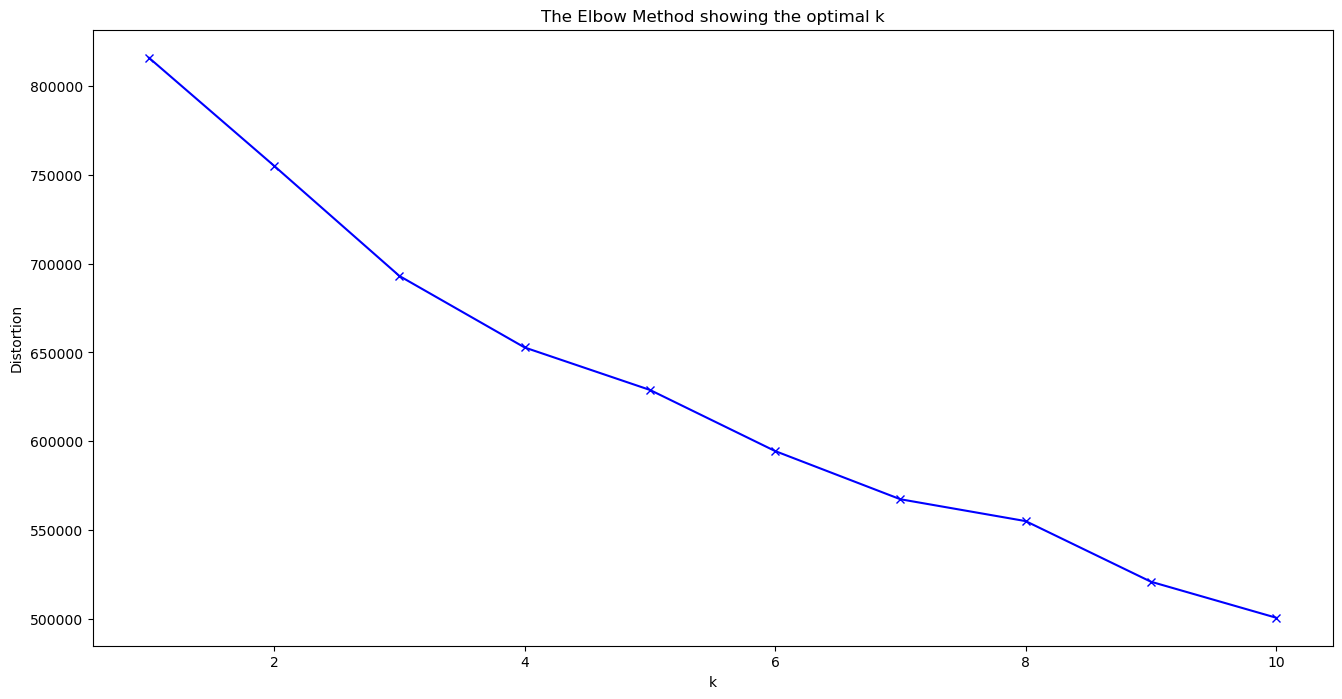

In [15]:
distortions = []
K = range(1, 11)  # Assuming we test for k values from 1 to 10
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0)
    kmeanModel.fit(pca_final_features)
    distortions.append(kmeanModel.inertia_)

#Plot the elbow curve
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [27]:
# From graph above:
optimal_k = 4

# Perform K-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
kmeans.fit(pca_final_features)
clusters = kmeans.labels_

# Assign clusters to original dataframe
df_clustering['cluster'] = clusters

C:\Users\rebec\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


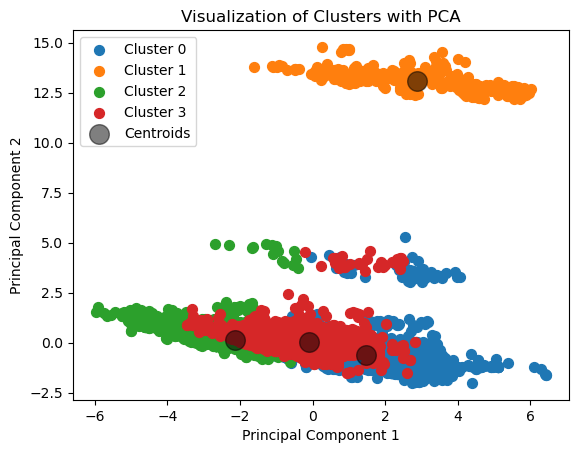

In [28]:
import matplotlib.pyplot as plt

# Plot each cluster
for i in range(optimal_k):
    # Select only data observations with cluster label == i
    ds = pca_final_features[clusters == i]
    # Plot the data observations
    plt.scatter(ds[:, 0], ds[:, 1], s=50, label=f'Cluster {i}')

# Plot the centroids of the clusters
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5, label='Centroids')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Visualization of Clusters with PCA')
plt.legend() 
plt.show()

## Step 4: Silhouette Score Evaluation

- We will calculate the **Silhouette Score** to see how well the clusters are separated.
- A higher score indicates a better-defined cluster (ranging from -1 to +1)

In [29]:
silhouette_avg = silhouette_score(pca_final_features, clusters)
print(f"The silhouette score for k={optimal_k}: {silhouette_avg:.2f}")

The silhouette score for k=4: 0.16


## Step 5: Pseudo Rand Index

Now we need to add in a thing to check if the recommended movies from the recommended column are in the correct clusters (or what percentage of them are).

In [30]:
df_clustering = df_clustering.drop_duplicates()
accuracy = []
for index, row in df_clustering.iterrows():
    try:
        #Get recommendation ID from current row
        current_cluster = row['cluster']
        same_cluster_count = 0
        recs_in_df = 1 #Avoid division by 0
    
        #Go through recommendation columns
        for i in range(1,6):
            #Get recommendation_{i} ID from current row
            rec_id = int(row[f'recommendation_{i}']) #rec_id is str
        
            #If recommended movie is in df 
            if rec_id in df_clustering['id'].values:
                recs_in_df += 1
               
                #Look up recommended movie's cluster
                rec_movie_cluster_row = df_clustering[df_clustering['id']==rec_id]['cluster']
                if rec_movie_cluster_row.empty == True:
                    same_cluster_count = 0
                else:
                    rec_movie_cluster = rec_movie_cluster_row.squeeze()
                    #print(rec_movie_cluster)
                    if rec_movie_cluster == current_cluster:
                        same_cluster_count += 1
    
        # Calculate the accuracy and append to the list
        accuracy.append((same_cluster_count/recs_in_df) * 100)
    except ValueError:
        accuracy.append(0)
        continue

# Add the counts as a new column in the DataFrame
df_clustering['clustering_accuracy_percent'] = accuracy
df_clustering['clustering_accuracy_percent']

0         50.000000
1         33.333333
2         80.000000
3         40.000000
4          0.000000
            ...    
714776    40.000000
717622    80.000000
717895    75.000000
719967    50.000000
721991    80.000000
Name: clustering_accuracy_percent, Length: 22275, dtype: float64

In [31]:
#Calculate overall accuracy across clusters
avg_accuracy = sum(accuracy)/len(accuracy)
avg_accuracy

45.54418256640543

## Step 6: Recommendation System

In [32]:
df_regression = df_clustering.copy()
def calculate_euclidean_distance(id, df_regression, clustering_column, feature_columns, df):

    # Get all members of the cluster from the clustering algorithm
    cluster_id = df_regression.loc[df_regression['id'] == id, clustering_column].values[0]
    cluster_data = df_regression[df_regression[clustering_column] == cluster_id]

    # Calculate euclidean distance
    id_features = df_regression.loc[df['id'] == id, feature_columns].values[0]
    cluster_features = cluster_data[feature_columns].values
    distances = np.linalg.norm(cluster_features - id_features, axis=1)

    # Create a new dataframe with it
    result_df = pd.DataFrame({
        'id': cluster_data['id'],
        'euclidean_distance': distances
    })
    result_df = pd.merge(result_df, df[['id', 'popularity', 'vote_average', 'vote_count']], on='id', how='left')

    return result_df

# This is how you put a movie in, we can change it to be a name instead but id seemed easier to not mess up
id_to_find = 615656

# These are presets, but I'm leaving them as a set (really we should define this higher up)
cluster_column = 'cluster'
feature_columns = ['revenue', 'release_year', 'is_english', 'runtime', 'Frank Welker', 'Eric Roberts', 'Mark Calaway', 'Mel Blanc', 'Paul Michael Lévesque', 'Bess Flowers', 'Allen Jones', 'Nedumudi Venu', 'KPAC Lalitha', 'Jagathy Sreekumar', 'Warner Bros. Pictures', 'Paramount', 'Metro', 'Goldwyn', 'Mayer', 'Universal Pictures', 'Columbia Pictures', 'Toei Company', 'ARTE', 'ZDF', 'Film', 'ONF | NFB', 'BBC', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']
result_df = calculate_euclidean_distance(id_to_find, df_regression, cluster_column, feature_columns, df)
print(result_df)

          id  euclidean_distance  popularity  vote_average  vote_count
0     615656        0.000000e+00    8763.998         7.079      1365.0
1     758323        2.863807e+08    5953.227         7.433       545.0
2     667538        5.498898e+07    5409.104         7.340      1007.0
3     640146        1.237097e+08    4425.387         6.507      2811.0
4     385687        3.526532e+08    3583.861         7.275      3694.0
...      ...                 ...         ...           ...         ...
7470  645740        3.520565e+08       0.600         5.800         4.0
7471  531181        3.520565e+08       0.600         6.500         5.0
7472  551649        3.520565e+08       0.600         5.000         3.0
7473  529864        3.520565e+08       0.600         7.200         3.0
7474  545548        3.520565e+08       0.600         7.400         4.0

[7475 rows x 5 columns]


Now we have the df that has euclidean distance within the cluster (and the 3 metrics that I thought were probably good for our regression) next is just to actually make and make the regression (either linear and return top X/all > some value or logistic and return all > than some value). 

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#Input movie using TMDB ID
def recommend_movies(id, euc_dist_df, df_copy):
    #Make temporary df with the recommendation columns from the result of euc_dist_df
    #euc_dist_df is the result_df output from calculate_euclidean_distance
    recommendation_cols_df = pd.merge(euc_dist_df[['id']], df_copy[['id', 'recommendation_1', 
                                                                 'recommendation_2', 'recommendation_3', 
                                                                 'recommendation_4', 'recommendation_5']], on='id', how='inner')
    working_df = pd.merge(euc_dist_df, recommendation_cols_df, on="id", how="left")
        
    #Regression to predict recommendations based on distance, etc.
    #Split data into training + testing for regression
    x = working_df[['euclidean_distance', 'vote_count', 'vote_average', 'popularity']]
    y = working_df[['recommendation_1']].values
    y_df = pd.DataFrame(y, columns=['recommendation_1'])
    x.dropna()
    y_df = y_df.dropna().reset_index(drop=True)
    common_indices = x.index.intersection(y_df.index)

    # Select only the rows that are present in both x and y_df
    x_aligned = x.loc[common_indices]
    y_aligned = y_df.loc[common_indices]
    
    x_train, x_test, y_train, y_test = train_test_split(x_aligned, y_aligned, test_size=0.2, random_state=42)
        
    #Create and train the regression model
    regression_model = LogisticRegression()
    regression_model.fit(x_train, y_train)
        
    #Predict recommendations for test set
    y_pred = regression_model.predict(x_test)
        
    #Evaluate model
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error of the Regression Model: {mse}')
        
    # Predict recommendation for all movies in the cluster
    all_recs = regression_model.predict(x)
        
    # Sort the movies based on predicted scores
    working_df['all_recs'] = all_recs
    
    return working_df['all_recs'].head()
    
#Try it out:
result_df = result_df.dropna()
df_copy = df_copy.dropna()
print(recommend_movies(615656, result_df, df_copy))

C:\Users\rebec\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\rebec\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Mean Squared Error of the Regression Model: 81733740769.23265
0    1006462
1     205321
2     205321
3     205321
4     205321
Name: all_recs, dtype: object
